In [4]:
# imports

import asyncio
import json
import os
import matplotlib
import neptune.new as neptune
import nest_asyncio
import numpy as np
import pandas as pd
import re
import time

from collections import defaultdict
from datetime import date
from itertools import product
from matplotlib import pyplot
from poke_env.environment.abstract_battle import AbstractBattle
from poke_env.player.battle_order import ForfeitBattleOrder
from poke_env.player.player import Player
# from poke_env.player.random_player import RandomPlayer
from scipy.interpolate import griddata
from src.PlayerQLearning import Player as PlayerQLearning


In [ ]:
# global configs

debug = True
save_to_json_file = True
use_validation = False
use_neptune = False

nest_asyncio.apply()
np.random.seed(0)

if use_neptune:
    run = neptune.init(project='leolellisr/rl-pokeenv',
                       api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1NjY1YmJkZi1hYmM5LTQ3M2QtOGU1ZC1iZTFlNWY4NjE1NDQifQ==',
                       tags=["Henrique", "Q-learning"])


In [ ]:
# our team

OUR_TEAM = """
Pikachu-Original (M) @ Light Ball  
Ability: Static  
EVs: 252 Atk / 4 SpD / 252 Spe  
Jolly Nature  
- Volt Tackle  
- Nuzzle  
- Iron Tail  
- Knock Off  

Charizard @ Life Orb  
Ability: Solar Power  
EVs: 252 SpA / 4 SpD / 252 Spe  
Timid Nature  
IVs: 0 Atk  
- Flamethrower  
- Dragon Pulse  
- Roost  
- Sunny Day  

Blastoise @ White Herb  
Ability: Torrent  
EVs: 4 Atk / 252 SpA / 252 Spe  
Mild Nature  
- Scald  
- Ice Beam  
- Earthquake  
- Shell Smash  

Venusaur @ Black Sludge  
Ability: Chlorophyll  
EVs: 252 SpA / 4 SpD / 252 Spe  
Modest Nature  
IVs: 0 Atk  
- Giga Drain  
- Sludge Bomb  
- Sleep Powder  
- Leech Seed  

Sirfetch’d @ Aguav Berry  
Ability: Steadfast  
EVs: 248 HP / 252 Atk / 8 SpD  
Adamant Nature  
- Close Combat  
- Swords Dance  
- Poison Jab  
- Knock Off  

Tauros (M) @ Assault Vest  
Ability: Intimidate  
EVs: 252 Atk / 4 SpD / 252 Spe  
Jolly Nature  
- Double-Edge  
- Earthquake  
- Megahorn  
- Iron Head  
"""


In [ ]:
# opponent's team

OP_TEAM = """
Eevee @ Eviolite  
Ability: Adaptability  
EVs: 252 HP / 252 Atk / 4 SpD  
Adamant Nature  
- Quick Attack  
- Flail  
- Facade  
- Wish  

Vaporeon @ Leftovers  
Ability: Hydration  
EVs: 252 HP / 252 Def / 4 SpA  
Bold Nature  
IVs: 0 Atk  
- Scald  
- Shadow Ball  
- Toxic  
- Wish  

Sylveon @ Aguav Berry  
Ability: Pixilate  
EVs: 252 HP / 252 SpA / 4 SpD  
Modest Nature  
IVs: 0 Atk  
- Hyper Voice  
- Mystical Fire  
- Psyshock  
- Calm Mind  

Jolteon @ Assault Vest  
Ability: Quick Feet  
EVs: 252 SpA / 4 SpD / 252 Spe  
Timid Nature  
IVs: 0 Atk  
- Thunderbolt  
- Hyper Voice  
- Volt Switch  
- Shadow Ball  

Leafeon @ Life Orb  
Ability: Chlorophyll  
EVs: 252 Atk / 4 SpD / 252 Spe  
Adamant Nature  
- Leaf Blade  
- Knock Off  
- X-Scissor  
- Swords Dance  

Umbreon @ Iapapa Berry  
Ability: Inner Focus  
EVs: 252 HP / 4 Atk / 252 SpD  
Careful Nature  
- Foul Play  
- Body Slam  
- Toxic  
- Wish  
"""


In [ ]:
N_OUR_MOVE_ACTIONS = 4
N_OUR_SWITCH_ACTIONS = 5
N_OUR_ACTIONS = N_OUR_MOVE_ACTIONS + N_OUR_SWITCH_ACTIONS

ALL_OUR_ACTIONS = np.array(range(0, N_OUR_ACTIONS))

NAME_TO_ID_DICT = {
    "pikachuoriginal": 0,
    "charizard": 1,
    "blastoise": 2,
    "venusaur": 3,
    "sirfetchd": 4,
    "tauros": 5,
    "eevee": 6,
    "vaporeon": 7,
    "sylveon": 8,
    "jolteon": 9,
    "leafeon": 10,
    "umbreon": 11
}


In [ ]:
# Max-damage player

class MaxDamagePlayer(Player):
    def choose_move(self, battle):
        if battle.available_moves:
            best_move = max(battle.available_moves, key=lambda move: move.base_power)
            return self.create_order(best_move)
        else:
            return self.choose_random_move(battle)


In [ ]:
# Q-learning player

class QLearningPlayer(PlayerQLearning):
    def __init__(self, battle_format, team, n0, gamma):
        super().__init__(battle_format=battle_format, team=team)
        self.N = defaultdict(lambda: np.zeros(N_OUR_ACTIONS))
        self.Q = defaultdict(lambda: np.zeros(N_OUR_ACTIONS))
        self.n0 = n0
        self.gamma = gamma
        self.state = None
        self.action = None

    def choose_move(self, battle):
        if self.state is not None:
            # observe R, S'
            reward = self.compute_reward(battle)
            next_state = self.embed_battle(battle)
            # Q-learning
            self.N[self.state][self.action] += 1
            alpha = 1.0 / self.N[self.state][self.action]
            self.Q[self.state][self.action] += \
                alpha * (reward + self.gamma * np.max(self.Q[next_state]) - self.Q[self.state][self.action])
            # S <- S'
            self.state = next_state
        else:
            # S first initialization
            self.state = self.embed_battle(battle)
            
        # Choose A from S using epsilon-greedy policy
        self.action = self.pi(self.state)

        # if the selected action is not possible, perform a random move instead
        if self.action == -1:
            return ForfeitBattleOrder()
        elif self.action < 4 and self.action < len(battle.available_moves) and not battle.force_switch:
            return self.create_order(battle.available_moves[self.action])
        elif 0 <= self.action - 4 < len(battle.available_switches):
            return self.create_order(battle.available_switches[self.action - 4])
        else:
            return self.choose_random_move(battle)

    def _battle_finished_callback(self, battle):
        if use_neptune:
            run[f'N0: {self.n0} gamma: {self.gamma} win_acc'].log(self.n_won_battles / len(self._reward_buffer))

    ''' Helper functions '''

    # epsilon-greedy policy
    def pi(self, state):
        epsilon = self.n0 / (self.n0 + np.sum(self.N[state]))
        # let's get the greedy action. Ties must be broken arbitrarily
        greedy_action = np.random.choice(np.where(self.Q[state] == self.Q[state].max())[0])
        action_pick_probability = np.full(N_OUR_ACTIONS, epsilon / N_OUR_ACTIONS)
        action_pick_probability[greedy_action] += 1 - epsilon
        return np.random.choice(ALL_OUR_ACTIONS, p=action_pick_probability)

    # the embed battle is our state
    # 12 factors: our active mon, opponent's active mon, 4 moves base power, 4 moves multipliers, num fainted mons
    @staticmethod
    def embed_battle(battle):
        # -1 indicates that the move does not have a base power
        # or is not available
        moves_base_power = -np.ones(4)
        moves_dmg_multiplier = np.ones(4)
        for i, move in enumerate(battle.available_moves):
            moves_base_power[i] = (
                    move.base_power / 100
            )  # Simple rescaling to facilitate learning
            if move.type:
                moves_dmg_multiplier[i] = move.type.damage_multiplier(
                    battle.opponent_active_pokemon.type_1,
                    battle.opponent_active_pokemon.type_2,
                )

        # We count how many pokemons have fainted in each team
        n_fainted_mon_team = (
            len([mon for mon in battle.team.values() if mon.fainted])
        )
        n_fainted_mon_opponent = (
            len([mon for mon in battle.opponent_team.values() if mon.fainted])
        )

        state = list()
        state.append(NAME_TO_ID_DICT[str(battle.active_pokemon).split(' ')[0]])
        state.append(NAME_TO_ID_DICT[str(battle.opponent_active_pokemon).split(' ')[0]])
        for move_base_power in moves_base_power:
            state.append('{0:.2f}'.format(move_base_power))
        for move_dmg_multiplier in moves_dmg_multiplier:
            state.append('{0:.2f}'.format(move_dmg_multiplier))
        state.append(n_fainted_mon_team)
        state.append(n_fainted_mon_opponent)

        return str(state)

    # Computing rewards
    def reward_computing_helper(
            self,
            battle: AbstractBattle,
            *,
            fainted_value: float = 0.15,
            hp_value: float = 0.15,
            number_of_pokemons: int = 6,
            starting_value: float = 0.0,
            status_value: float = 0.15,
            victory_value: float = 1.0
    ) -> float:
        # 1st compute
        if battle not in self._reward_buffer:
            self._reward_buffer[battle] = starting_value
        current_value = 0

        # Verify if pokemon have fainted or have status
        for mon in battle.team.values():
            current_value += mon.current_hp_fraction * hp_value
            if mon.fainted:
                current_value -= fainted_value
            elif mon.status is not None:
                current_value -= status_value

        current_value += (number_of_pokemons - len(battle.team)) * hp_value

        # Verify if opponent pokemon have fainted or have status
        for mon in battle.opponent_team.values():
            current_value -= mon.current_hp_fraction * hp_value
            if mon.fainted:
                current_value += fainted_value
            elif mon.status is not None:
                current_value += status_value

        current_value -= (number_of_pokemons - len(battle.opponent_team)) * hp_value

        # Verify if we won or lost
        if battle.won:
            current_value += victory_value
        elif battle.lost:
            current_value -= victory_value

        # Value to return
        to_return = current_value - self._reward_buffer[battle]
        self._reward_buffer[battle] = current_value
        if use_neptune:
            run[f'N0: {self.n0} gamma: {self.gamma} reward_buffer'].log(current_value)
        return to_return

    # Calling reward_computing_helper
    def compute_reward(self, battle) -> float:
        return self.reward_computing_helper(battle, fainted_value=2, hp_value=1, victory_value=15)


In [ ]:
# validation player

class ValidationPlayer(PlayerQLearning):
    def __init__(self, battle_format, team, q):
        super().__init__(battle_format=battle_format, team=team)
        self.Q = q

    def choose_move(self, battle):
        state = self.embed_battle(battle)
        # let's get the greedy action. Ties must be broken arbitrarily
        if state in self.Q.keys():
            action = np.random.choice(np.where(self.Q[state] == self.Q[state].max())[0])
        else:
            return self.choose_random_move(battle)

        # if the selected action is not possible, perform a random move instead
        if action == -1:
            return ForfeitBattleOrder()
        elif action < 4 and action < len(battle.available_moves) and not battle.force_switch:
            return self.create_order(battle.available_moves[action])
        elif 0 <= action - 4 < len(battle.available_switches):
            return self.create_order(battle.available_switches[action - 4])
        else:
            return self.choose_random_move(battle)

    def _battle_finished_callback(self, battle):
        pass

    # the embed battle is our state
    # 12 factors: our active mon, opponent's active mon, 4 moves base power, 4 moves multipliers, num fainted mons
    @staticmethod
    def embed_battle(battle):
        # -1 indicates that the move does not have a base power
        # or is not available
        moves_base_power = -np.ones(4)
        moves_dmg_multiplier = np.ones(4)
        for i, move in enumerate(battle.available_moves):
            moves_base_power[i] = (
                    move.base_power / 100
            )  # Simple rescaling to facilitate learning
            if move.type:
                moves_dmg_multiplier[i] = move.type.damage_multiplier(
                    battle.opponent_active_pokemon.type_1,
                    battle.opponent_active_pokemon.type_2,
                )

        # We count how many pokemons have fainted in each team
        n_fainted_mon_team = (
            len([mon for mon in battle.team.values() if mon.fainted])
        )
        n_fainted_mon_opponent = (
            len([mon for mon in battle.opponent_team.values() if mon.fainted])
        )

        state = list()
        state.append(NAME_TO_ID_DICT[str(battle.active_pokemon).split(' ')[0]])
        state.append(NAME_TO_ID_DICT[str(battle.opponent_active_pokemon).split(' ')[0]])
        for move_base_power in moves_base_power:
            state.append('{0:.2f}'.format(move_base_power))
        for move_dmg_multiplier in moves_dmg_multiplier:
            state.append('{0:.2f}'.format(move_dmg_multiplier))
        state.append(n_fainted_mon_team)
        state.append(n_fainted_mon_opponent)

        return str(state)


In [ ]:
# global parameters

# possible values for num_battles (number of episodes)
n_battles_array = [10000]
# exploration schedule from MC, i. e., epsilon(t) = N0 / (N0 + N(S(t)))
n0_array = [0.0001, 0.001, 0.01]
# possible values for gamma (discount factor)
gamma_array = [0.75]

list_of_params = [
    {
        'n_battles': n_battles,
        'n0': n0,
        'gamma': gamma
    } for n_battles, n0, gamma in product(n_battles_array, n0_array, gamma_array)
]


In [ ]:
# json helper functions

def save_dict_to_json(path_dir, filename, data, append=True):
    if not os.path.exists(path_dir):
        os.makedirs(path_dir)
    full_filename = path_dir + "/" + filename
    if os.path.exists(full_filename) and append:
        with open(full_filename, "r") as file:
            value_dict = json.load(file)
            for key in data:
                value_dict[key] = data[key] if isinstance(data[key], list) else data[key].tolist()
            file.close()
    else:
        value_dict = dict()
        for key in data:
            value_dict[key] = data[key] if isinstance(data[key], list) else data[key].tolist()
    # write
    with open(full_filename, "w") as file:
        json.dump(value_dict, file)
        file.close()


def read_dict_from_json(path_dir, filename):
    full_filename = path_dir + "/" + filename
    if not os.path.exists(full_filename):
        return dict()
    file = open(full_filename, "r")
    data = json.load(file)
    file.close()
    return data


In [ ]:
# main (let's battle!)

# training
async def do_battle_training():
    for params in list_of_params:
        start = time.time()
        if use_neptune:
            run['params'] = params
        params['player'] = QLearningPlayer(battle_format="gen8ou", team=OUR_TEAM, n0=params['n0'], gamma=params['gamma'])
        params['opponent'] = MaxDamagePlayer(battle_format="gen8ou", team=OP_TEAM)
        await params['player'].battle_against(opponent=params['opponent'], n_battles=params['n_battles'])
        if debug:
            print("training: num battles (episodes)=%d, N0=%.4f, gamma=%.2f, wins=%d, winning %%=%.2f, total time=%s sec" %
                  (
                      params['n_battles'],
                      round(params['n0'], 4),
                      round(params['gamma'], 2),
                      params['player'].n_won_battles,
                      round((params['player'].n_won_battles / params['n_battles']) * 100, 2),
                      round(time.time() - start, 2)
                  ))

        # save Q to json file
        if save_to_json_file:
            today_s = str(date.today())
            n_battle_s = str(params['n_battles'])
            n0_s = str(round(params['n0'], 4))
            gamma_s = str(round(params['gamma'], 2))
            winning_percentage_s = str(round((params['player'].n_won_battles / params['n_battles']) * 100, 2))
            filename = "Q_" + today_s + "_" + n_battle_s + "_" + n0_s + "_" + gamma_s + "_" + winning_percentage_s + ".json"
            save_dict_to_json("./Q_Learning_table", filename, params['player'].Q, False)

        # statistics: key: "n_battles, n0, gamma", values: list of win or lose
        key = str(params['n_battles']) + "_" + str(round(params['n0'], 4)) + "_" + str(round(params['gamma'], 2))
        winning_status = list()
        for battle in params['player']._battles.values():
            if battle.won:
                winning_status.append(True)
            else:
                winning_status.append(False)
        # save statistics json file (append)
        data = dict()
        data[key] = winning_status
        save_dict_to_json("./Q_Learning_statistics", "statistics.json", data)
    if use_neptune:
        run.stop()


loop = asyncio.get_event_loop()
loop.run_until_complete(loop.create_task(do_battle_training()))


In [ ]:
# validation vs maxPlayer

async def do_battle_validation(path_dir):
    # read from json
    for filename in os.listdir(path_dir):
        # Q-learned table
        q = defaultdict()
        q_json = read_dict_from_json(path_dir, filename)
        for key in q_json.keys():
            q[key] = np.array(q_json[key])
        # params: n_battles, n0, gamma
        params = filename.split("_")
        n_battles = int(params[2])
        n0 = float(params[3])
        gamma = float(params[4])

        # validation (play 1/3 of the battles using Q-learned table)
        start = time.time()
        validation_player = ValidationPlayer(battle_format="gen8ou", team=OUR_TEAM, q=q)
        opponent = MaxDamagePlayer(battle_format="gen8ou", team=OP_TEAM)
        n_battles_validation = int(n_battles / 3)
        await validation_player.battle_against(opponent=opponent, n_battles=n_battles_validation)
        print("validation: num battles (episodes)=%d, N0=%.4f, gamma=%.2f, wins=%d, winning %%=%.2f, total time=%s sec" %
              (
                  n_battles_validation,
                  n0,
                  gamma,
                  validation_player.n_won_battles,
                  round((validation_player.n_won_battles / n_battles_validation) * 100, 2),
                  round(time.time() - start, 2)
              ))


if use_validation:
    loop = asyncio.get_event_loop()
    loop.run_until_complete(loop.create_task(do_battle_validation("./Q_Learning_table")))


In [ ]:
# validation vs randomPlayer

async def do_battle_validation(path_dir):
    # read from json
    for filename in os.listdir(path_dir):
        # Q-learned table
        q = defaultdict()
        q_json = read_dict_from_json(path_dir, filename)
        for key in q_json.keys():
            q[key] = np.array(q_json[key])
        # params: n_battles, n0, gamma
        params = filename.split("_")
        n_battles = int(params[2])
        n0 = float(params[3])
        gamma = float(params[4])

        # validation (play 1/3 of the battles using Q-learned table)
        start = time.time()
        validation_player = ValidationPlayer(battle_format="gen8ou", team=OUR_TEAM, q=q)
        opponent = MaxDamagePlayer(battle_format="gen8ou", team=OP_TEAM)
        n_battles_validation = int(n_battles / 3)
        await validation_player.battle_against(opponent=opponent, n_battles=n_battles_validation)
        print("validation: num battles (episodes)=%d, N0=%.4f, gamma=%.2f, wins=%d, winning %%=%.2f, total time=%s sec" %
              (
                  n_battles_validation,
                  n0,
                  gamma,
                  validation_player.n_won_battles,
                  round((validation_player.n_won_battles / n_battles_validation) * 100, 2),
                  round(time.time() - start, 2)
              ))


if use_validation:
    loop = asyncio.get_event_loop()
    loop.run_until_complete(loop.create_task(do_battle_validation("./Q_Learning_table")))

In [1]:
import os
import json
import re
from datetime import date
today = date.today()


In [7]:
from matplotlib import pyplot as plt


In [2]:
output_folder = "images/vfunction"

In [13]:
# x: index_pokemon*20+sum(moves_base_power * moves_dmg_multiplier)
# y: remaining_mon_team - remaining_mon_opponent
# z: value function
v_array = []
directoryQ = r'S:\poke_env\dump\211104\Q_Learning_table'

for filenameQ in os.listdir(directoryQ):
    Qjson_file = open(directoryQ+'/'+filenameQ,)
    Qjson = json.load(Qjson_file)

    for key in Qjson:
        Qjson[key] = np.array(Qjson[key])
        
    z_values = []
    x_values = []
    y_values = []
    #for state, actions in test['player_val'].Q.items():
    for state, actions in Qjson.items():    
        action_value = np.max(actions)
        z_values.append(action_value)
        state = re.sub(r"[,!?><:'\[\]()@*~#]","", state)
        key_float = [float(k) for k in state.split()]
        x_emb = key_float[0]*20+key_float[1]*key_float[5]+key_float[2]*key_float[6]+key_float[3]*key_float[7]+key_float[4]*key_float[8]
        x_values.append(x_emb)
        y_emb = key_float[8]-key_float[9]
        y_values.append(y_emb)
        #V[x_emb,y_emb] = action_value
    v_array.append((x_values, y_values, z_values))

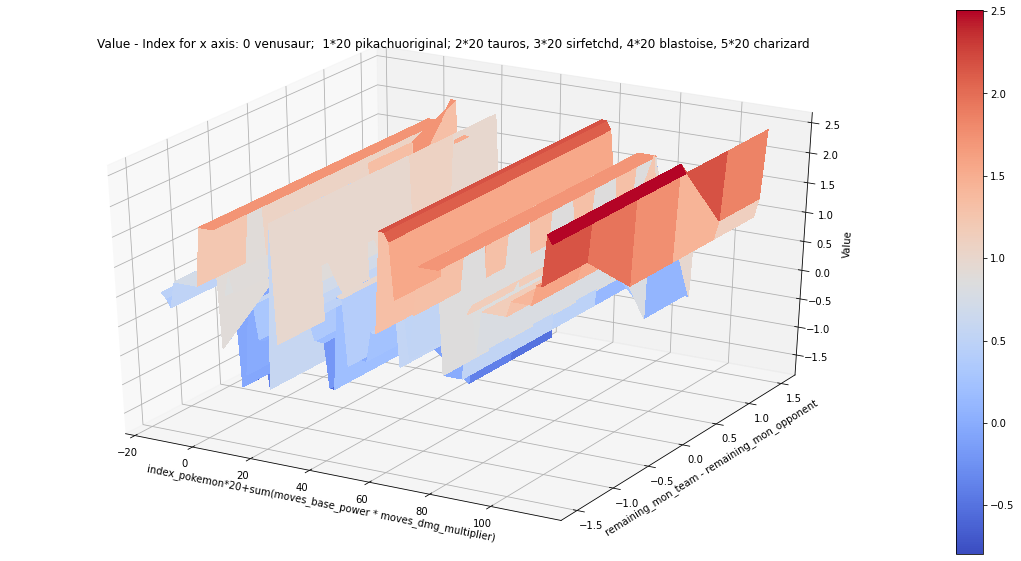

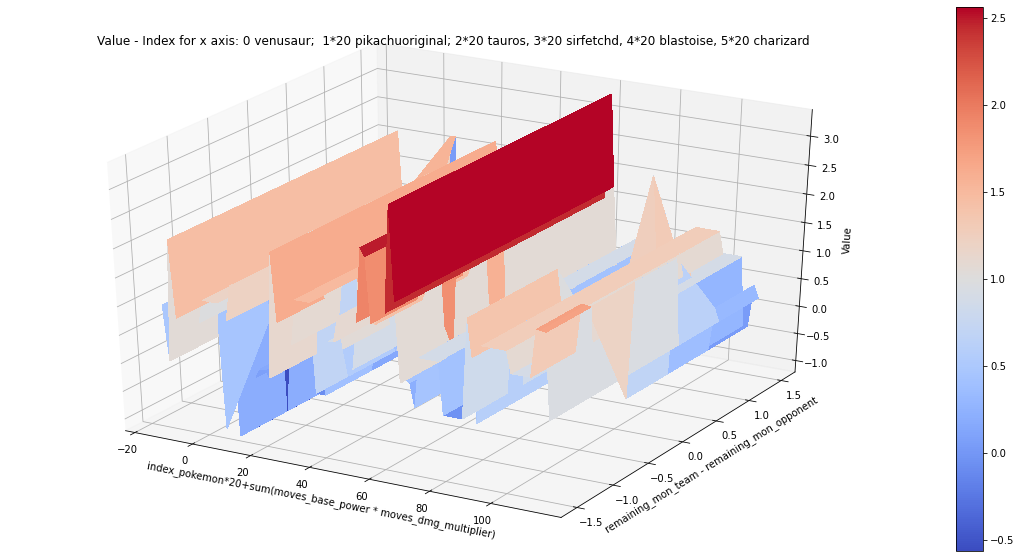

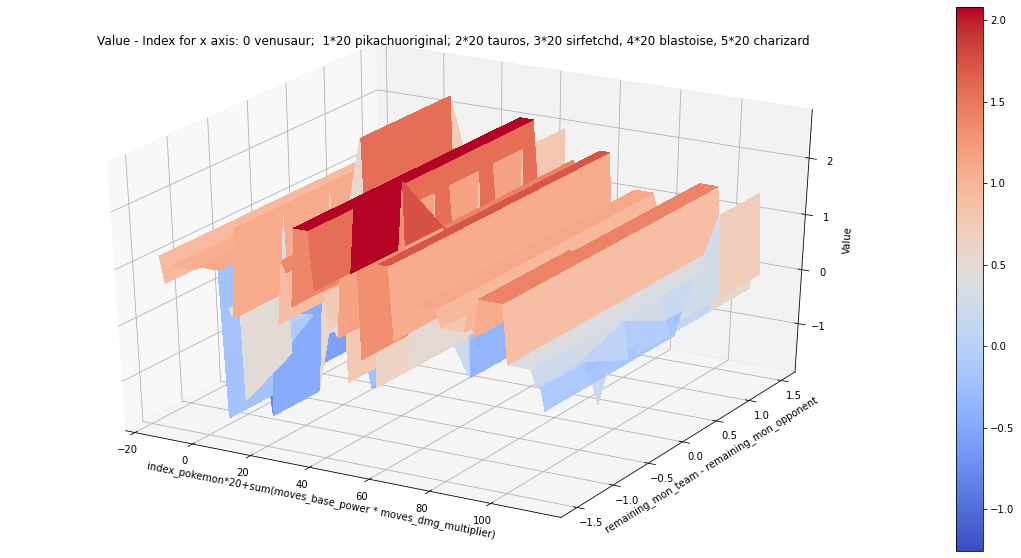

In [14]:
# x: index_pokemon*20+sum(moves_base_power * moves_dmg_multiplier)
# y: remaining_mon_team - remaining_mon_opponent
# z: value function
import pandas as pd
from scipy.interpolate import griddata
# create 1D-arrays from the 2D-arrays
for vvalue, filenameQ in zip(v_array, os.listdir(directoryQ)):
    filenameQ = re.sub(r"[,.!?><:'\[\]()@*~#]","_", filenameQ)
    x_values, y_values, z_values = vvalue 
    z_plot = np.array(z_values).reshape(len(z_values),1)
    x_plot = np.array(x_values)
    y_plot = np.array(y_values)
    xyz = {'x': x_plot, 'y': y_plot, 'z': np.array(z_values)}
    df = pd.DataFrame(xyz, index=range(len(xyz['x']))) 
    x1 = np.linspace(df['x'].min(), df['x'].max(), len(df['x'].unique()))
    y1 = np.linspace(df['y'].min(), df['y'].max(), len(df['y'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    z2 = griddata((df['x'], df['y']), df['z'], (x2, y2), method='nearest')

    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('index_pokemon*20+sum(moves_base_power * moves_dmg_multiplier)')
    ax.set_ylabel('remaining_mon_team - remaining_mon_opponent')
    ax.set_zlabel('Value')
    ax.set_title('Value - Index for x axis: 0 venusaur;  1*20 pikachuoriginal; 2*20 tauros, 3*20 sirfetchd, 4*20 blastoise, 5*20 charizard')

    surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm,
        linewidth=0, antialiased=False)
    fig.colorbar(surf)
    filename = filenameQ+'_Stoc_Index.pdf'
    path_plot = output_folder+'/QLearning/'
    if not os.path.exists(path_plot):
        os.makedirs(path_plot)
    plt.savefig(path_plot+filename) 
    plt.show()

In [15]:
# x: sum(moves_base_power * moves_dmg_multiplier)
# y: remaining_mon_team - remaining_mon_opponent
# z: value function

v_array = []
directoryQ = r'S:\poke_env\dump\211104\Q_Learning_table'

for filenameQ in os.listdir(directoryQ):
    Qjson_file = open(directoryQ+'/'+filenameQ,)
    Qjson = json.load(Qjson_file)

    for key in Qjson:
        Qjson[key] = np.array(Qjson[key])
        
    z_values = []
    x_values = []
    y_values = []

    for state, actions in Qjson.items():    
        action_value = np.max(actions)
        z_values.append(action_value)
        state = re.sub(r"[,!?><:'\[\]()@*~#]","", state)
        key_float = [float(k) for k in state.split()]
        x_emb = key_float[1]*key_float[5]+key_float[2]*key_float[6]+key_float[3]*key_float[7]+key_float[4]*key_float[8]
        x_values.append(x_emb)
        y_emb = key_float[8]-key_float[9]
        y_values.append(y_emb)
        #V[x_emb,y_emb] = action_value
    v_array.append((x_values, y_values, z_values))

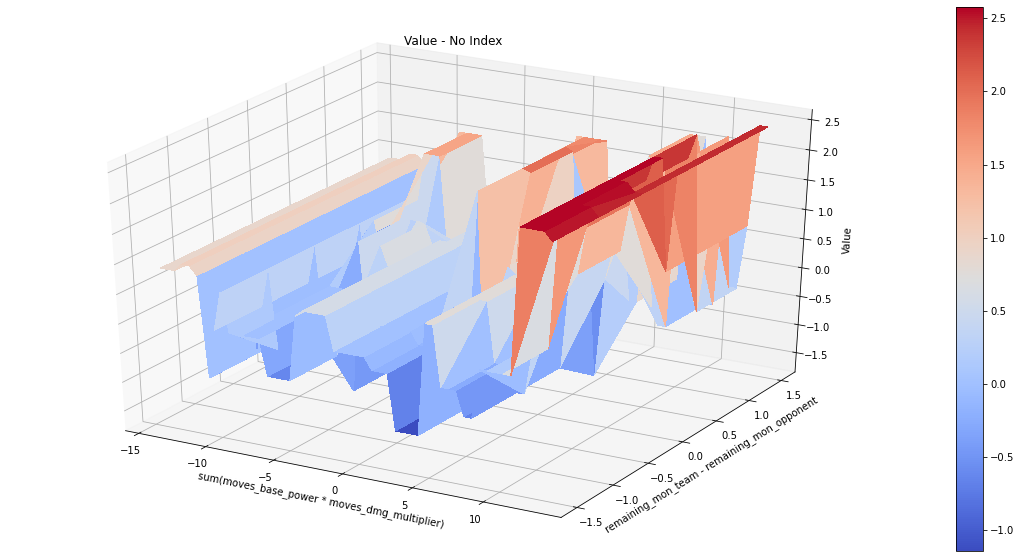

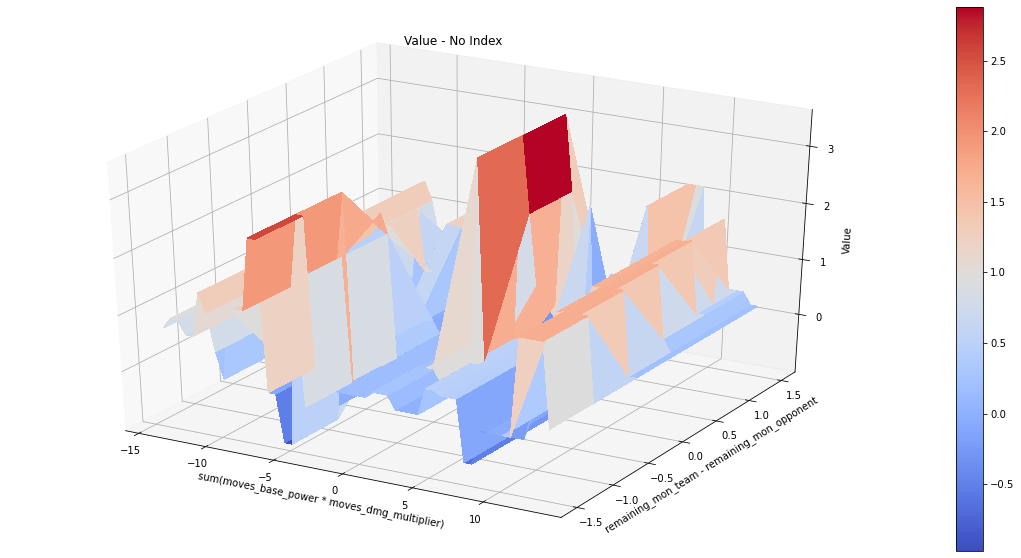

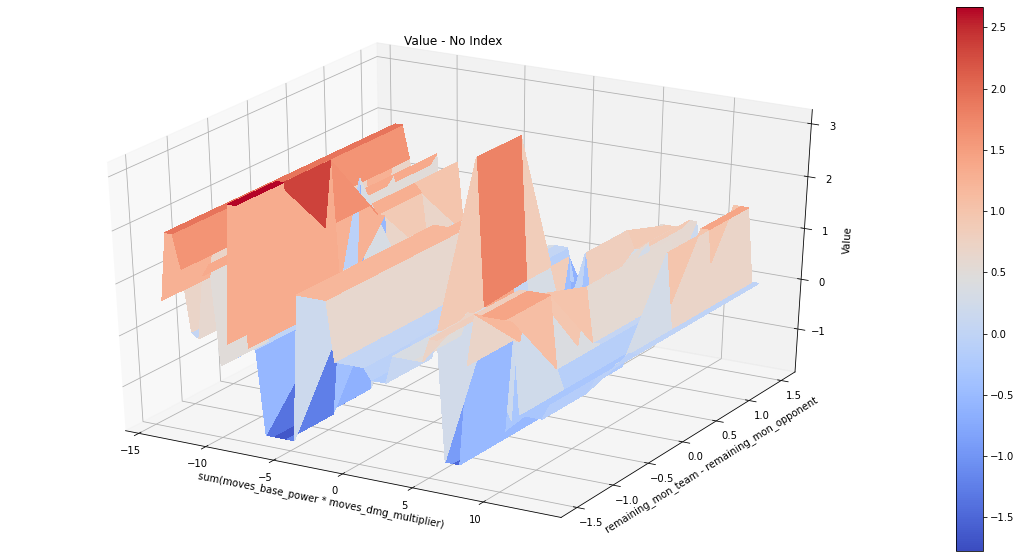

In [16]:
# x: sum(moves_base_power * moves_dmg_multiplier)
# y: remaining_mon_team - remaining_mon_opponent
# z: value function
import pandas as pd
from scipy.interpolate import griddata
# create 1D-arrays from the 2D-arrays
for vvalue, filenameQ in zip(v_array, os.listdir(directoryQ)):
    filenameQ = re.sub(r"[,!?.><:'\[\]()@*~#]","_", filenameQ)
    x_values, y_values, z_values = vvalue 
    z_plot = np.array(z_values).reshape(len(z_values),1)
    x_plot = np.array(x_values)
    y_plot = np.array(y_values)
    xyz = {'x': x_plot, 'y': y_plot, 'z': np.array(z_values)}
    df = pd.DataFrame(xyz, index=range(len(xyz['x']))) 
    x1 = np.linspace(df['x'].min(), df['x'].max(), len(df['x'].unique()))
    y1 = np.linspace(df['y'].min(), df['y'].max(), len(df['y'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    z2 = griddata((df['x'], df['y']), df['z'], (x2, y2), method='nearest')

    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('sum(moves_base_power * moves_dmg_multiplier)')
    ax.set_ylabel('remaining_mon_team - remaining_mon_opponent')
    ax.set_zlabel('Value')
    ax.set_title('Value - No Index')

    surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm,
        linewidth=0, antialiased=False)
    fig.colorbar(surf)
    filename = filenameQ+'_Stoc_noIndex.pdf'
    path_plot = output_folder+'/QLearning/'
    if not os.path.exists(path_plot):
        os.makedirs(path_plot)
    plt.savefig(path_plot+filename) 
    plt.show()

In [17]:
# x: (remaining_mon_team - remaining_mon_opponent)*sum(moves_base_power * moves_dmg_multiplier)
# y: action
# z: value function
v_array = []
directoryQ = r'S:\poke_env\dump\211104\Q_Learning_table'

for filenameQ in os.listdir(directoryQ):
    Qjson_file = open(directoryQ+'/'+filenameQ,)
    Qjson = json.load(Qjson_file)

    for key in Qjson:
        Qjson[key] = np.array(Qjson[key])
        
    z_values = []
    x_values = []
    y_values = []
    for state, actions in Qjson.items(): 
        
        action_value = np.max(actions)
        z_values.append(action_value)
        state = re.sub(r"[,!?><:'\[\]()@*~#]","", state)
        key_float = [float(k) for k in state.split()]
        x_emb = (key_float[8]-key_float[9])*(key_float[1]*key_float[5]+key_float[2]*key_float[6]+key_float[3]*key_float[7]+key_float[4]*key_float[8])
        x_values.append(x_emb)
        y_emb = np.argmax(actions)
        y_values.append(y_emb)
        #V[x_emb,y_emb] = action_value
    v_array.append((x_values, y_values, z_values))

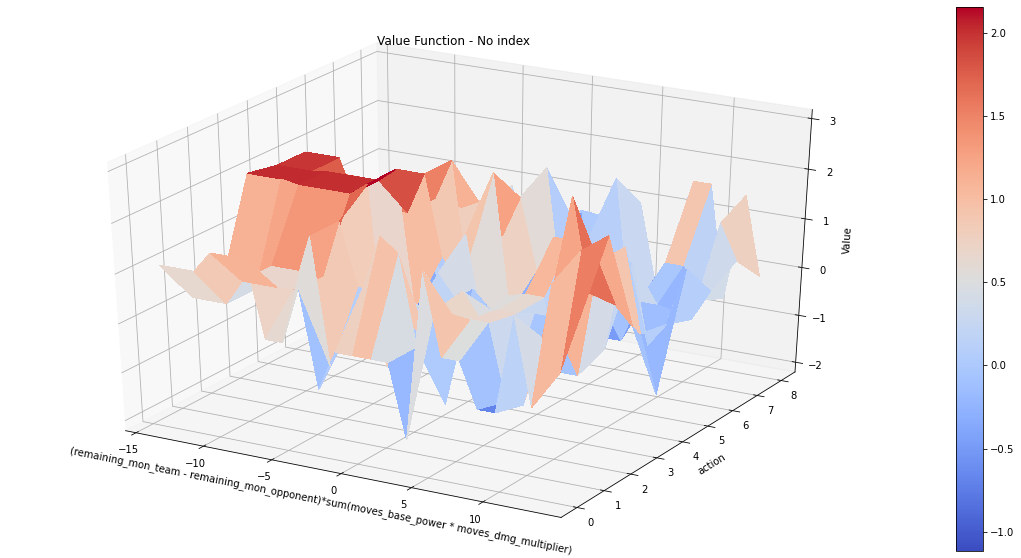

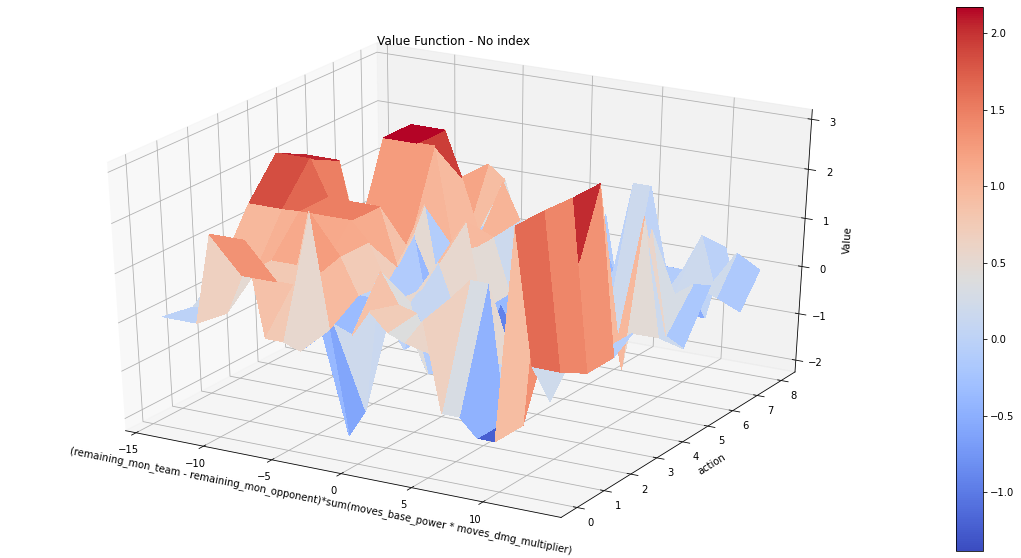

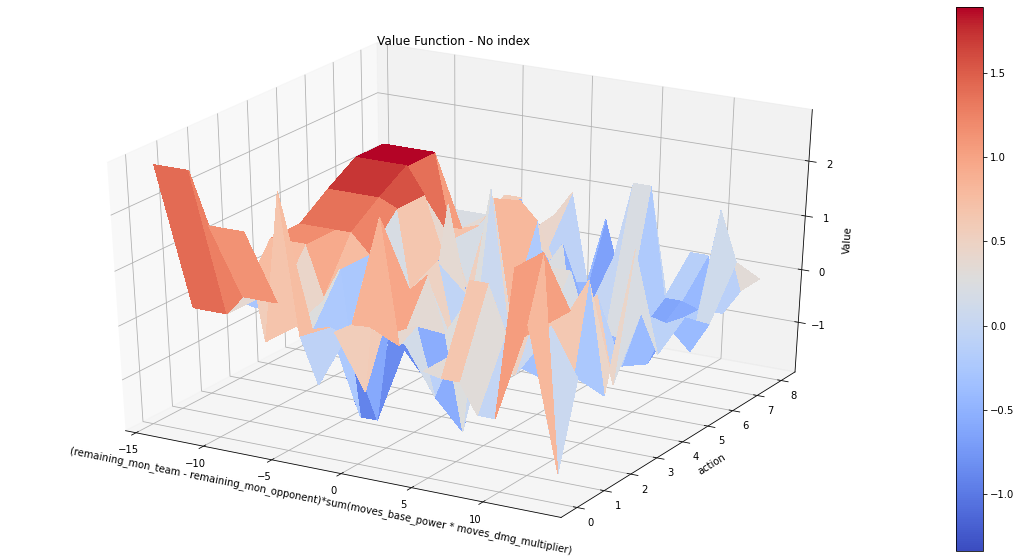

In [18]:
# x: (remaining_mon_team - remaining_mon_opponent)*sum(moves_base_power * moves_dmg_multiplier)
# y: action
# z: value function

import pandas as pd
from scipy.interpolate import griddata
for vvalue, filenameQ in zip(v_array, os.listdir(directoryQ)):
    filenameQ = re.sub(r"[,!?.><:'\[\]()@*~#]","_", filenameQ)
    x_values, y_values, z_values = vvalue 
    z_plot = np.array(z_values).reshape(len(z_values),1)
    x_plot = np.array(x_values)
    y_plot = np.array(y_values)
    xyz = {'x': x_plot, 'y': y_plot, 'z': np.array(z_values)}
    df = pd.DataFrame(xyz, index=range(len(xyz['x']))) 
    x1 = np.linspace(df['x'].min(), df['x'].max(), len(df['x'].unique()))
    y1 = np.linspace(df['y'].min(), df['y'].max(), len(df['y'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    z2 = griddata((df['x'], df['y']), df['z'], (x2, y2), method='nearest')

    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('(remaining_mon_team - remaining_mon_opponent)*sum(moves_base_power * moves_dmg_multiplier)')
    ax.set_ylabel('action')
    ax.set_zlabel('Value')
    ax.set_title('Value Function - No index')

    surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm,
        linewidth=0, antialiased=False)
    fig.colorbar(surf)
    filename = filenameQ+'_Stoc_noIndex_action.pdf'
    path_plot = output_folder+'/QLearning/'
    if not os.path.exists(path_plot):
        os.makedirs(path_plot)
    plt.savefig(path_plot+filename)     
    plt.show()    